# Texas Scraper from Excel Sheet and historical CRDT data

In [8]:
from selenium import webdriver
from bs4 import BeautifulSoup
import zipfile
import pandas as pd
from io import StringIO
import requests
import csv
import time
import random
import matplotlib.pyplot as plt

# Creating Dataframe for TX Demographics by exporting their CSV

In [11]:
# NOTE: TX only updates their demographic data once a week on Fridays


# This is the URL to the xlsx file where TX reports their data for 'Cases by Race/Ethnicity' and 
# 'Fatalities by Race/Ethnicity'
TexasXlslUrl = "https://dshs.texas.gov/coronavirus/TexasCOVID19Demographics.xlsx.asp"

# The texas CSV file has multiple sheets within it, each for different data such as 'Cases by Age Group',
# 'Cases by Gender', etc. 
# Since we are interested in Race/Ethnicity data, we will read only the relevant sheets
# The following line of code reads from the sheet named 'Cases by RaceEthnicity'
casesByRaceAndEthnicity = pd.read_excel(TexasXlslUrl, "Cases by RaceEthnicity")

# Before displaying this dataframe, if you were to open the CSV you'd see that the sheet is organized in 
# three columns: "Race/Ethnicity, Number, and %"
# To help us distinguish between the data for cases and fatalities, let's rename the 'Number' column 
# to 'Number of Cases'
casesByRaceAndEthnicity.rename(columns = {'Number':'Number of Cases'}, inplace = True)

# Let's display this dataframe
casesByRaceAndEthnicity

,Race/Ethnicity,Number of Cases,%
0,Asian,892,0.013841
1,Black,10582,0.164197
2,Hispanic,25189,0.390848
3,Other,308,0.004779
4,White,19552,0.303381
5,Unknown,7924,0.122954
6,Total,64447,1.000000


In [12]:
# We also want to get the data from the sheet titled 'Fatalities by Race-Ethnicity'
deathsByRaceAndEthnicity = pd.read_excel(TexasXlslUrl, "Fatalities by Race-Ethnicity")

# Recall how we renamed the 'Number' column above to help us distinguish between the data? 
# Let's do the same here, except we'll rename to 'Number of Deaths' this time
deathsByRaceAndEthnicity.rename(columns = {'Number':'Number of Deaths'}, inplace = True)

# Let's go ahead and display this dataframe as well
deathsByRaceAndEthnicity

,Race/Ethnicity,Number of Deaths,%
0,Asian,418,0.017738
1,Black,2405,0.102058
2,Hispanic,12318,0.522724
3,Other,117,0.004965
4,White,8293,0.351920
5,Unknown,14,0.000594
6,Total,23565,1.000000


# Visualizing the Race and Ethnicity Data

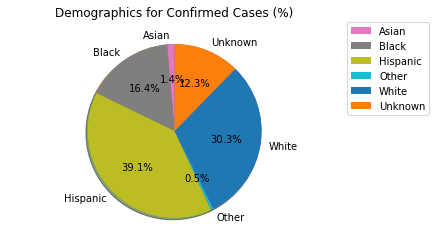

In [20]:
# Now that we have built our two dataframes, let's visualize the data using pie charts
# Pie chart for 'Demographics for Confirmed Cases (%)'

# array to store our labels for the pie chart, these will match the labels from the dataframes above (excluding total)
labels = 'Asian', 'Black', 'Hispanic', 'Other', 'White', 'Unknown'
# get the 'Number of cases' for each of our labels
# We do this by telling our code to go to the respective column for the race/ethnicity we want the data for
sizes = [casesByRaceAndEthnicity.loc[0, 'Number of Cases'], casesByRaceAndEthnicity.loc[1, 'Number of Cases'], casesByRaceAndEthnicity.loc[2, 'Number of Cases'], casesByRaceAndEthnicity.loc[3, 'Number of Cases'], casesByRaceAndEthnicity.loc[4, 'Number of Cases'], casesByRaceAndEthnicity.loc[5, 'Number of Cases']]
explode = (0, 0, 0, 0, 0, 0)
fig1, ax1 = plt.subplots()
pie = ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
ax1.axis('equal')
patches, texts = plt.pie(sizes, startangle=90)
# create a legend for the pie chart
plt.legend(patches,labels, bbox_to_anchor=(1,1.025), loc="upper left")
# title the chart
plt.title('Demographics for Confirmed Cases (%)')

# display our pie chart
plt.show()


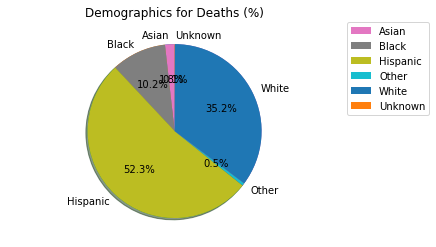

In [21]:
# Pie chart for 'Demographics for Deaths (%)'

# array to store our labels for the pie chart, these will match the labels from the dataframes above (excluding total)
labels = 'Asian', 'Black', 'Hispanic', 'Other', 'White', 'Unknown'
# get the 'Number of Deaths' for each of our labels
# We do this by telling our code to go to the respective column for the race/ethnicity we want the data for
sizes = [deathsByRaceAndEthnicity.loc[0, 'Number of Deaths'], deathsByRaceAndEthnicity.loc[1, 'Number of Deaths'], deathsByRaceAndEthnicity.loc[2, 'Number of Deaths'], deathsByRaceAndEthnicity.loc[3, 'Number of Deaths'], deathsByRaceAndEthnicity.loc[4, 'Number of Deaths'], deathsByRaceAndEthnicity.loc[5, 'Number of Deaths']]
explode = (0, 0, 0, 0, 0, 0)
fig1, ax1 = plt.subplots()
pie = ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
ax1.axis('equal')
patches, texts = plt.pie(sizes, startangle=90)
# create a legend for the pie chart
plt.legend(patches,labels, bbox_to_anchor=(1,1.025), loc="upper left")
# title the chart
plt.title('Demographics for Deaths (%)')

# display our pie chart
plt.show()

# Historical Data for Texas

In [91]:
# Unfortunately, Texas doesn't report historical data for their race and demographics
# Luckily, we can use the CRDT historical data sheet to create a dataframe for TX containing all this data

# Let's start by importing the CRDT historical data CSV

# URL for CRDT sheet
crdtHistoricalDataCSV = "https://docs.google.com/spreadsheets/d/e/2PACX-1vS8SzaERcKJOD_EzrtCDK1dX1zkoMochlA9iHoHg_RSw3V8bkpfk1mpw4pfL5RdtSOyx_oScsUtyXyk/pub?gid=43720681&single=true&output=csv"
# Read from CSV to create our data frame
crdtHistoricalData = pd.read_csv(crdtHistoricalDataCSV)

# to help with plotting data from this dataframe later on, let's convert the data column to datetime data
crdtHistoricalData['Date']= pd.to_datetime(crdtHistoricalData['Date'].astype(str), format='%Y%m%d')
# the CRDT CSV includes data for all states and territories we collect data from
# Since we are only focusing on TX, let's filter our dataframe
texasHistorical = crdtHistoricalData.loc[crdtHistoricalData['State']=='TX'].reset_index()
# Let's drop the state column since we no longer need it as we are only viewing TX data
texasHistorical.drop('State', inplace=True, axis=1)
del texasHistorical['index']
# To be able to plot, we need to ensure everything can be considered numeric
cols = texasHistorical.columns
texasHistorical.replace(',','', regex=True, inplace=True)
texasHistorical.Cases_White=pd.to_numeric(texasHistorical.Cases_White)
texasHistorical.Cases_Total=pd.to_numeric(texasHistorical.Cases_Total)
texasHistorical.Cases_LatinX=pd.to_numeric(texasHistorical.Cases_LatinX)
texasHistorical.Cases_Asian=pd.to_numeric(texasHistorical.Cases_Asian)
texasHistorical.Cases_Black=pd.to_numeric(texasHistorical.Cases_Black)
texasHistorical.Cases_Other=pd.to_numeric(texasHistorical.Cases_Other)
texasHistorical.Cases_Other=pd.to_numeric(texasHistorical.Cases_Unknown)
texasHistorical.Deaths_Total=pd.to_numeric(texasHistorical.Deaths_Total)
texasHistorical.Deaths_LatinX=pd.to_numeric(texasHistorical.Deaths_LatinX)
texasHistorical.Deaths_Black=pd.to_numeric(texasHistorical.Deaths_Black)
texasHistorical.Deaths_White=pd.to_numeric(texasHistorical.Deaths_White)
texasHistorical.Deaths_Asian=pd.to_numeric(texasHistorical.Deaths_Asian)
texasHistorical.Deaths_Other=pd.to_numeric(texasHistorical.Deaths_Other)
texasHistorical.Deaths_Unknown=pd.to_numeric(texasHistorical.Deaths_Unknown) 

# Let's display our dataframe, notice that TX doesn't report data for testing and Hospitalizations, so these columns are empty
texasHistorical

,Date,Cases_Total,Cases_White,Cases_Black,Cases_LatinX,Cases_Asian,Cases_AIAN,Cases_NHPI,Cases_Multiracial,Cases_Other,...,Tests_LatinX,Tests_Asian,Tests_AIAN,Tests_NHPI,Tests_Multiracial,Tests_Other,Tests_Unknown,Tests_Ethnicity_Hispanic,Tests_Ethnicity_NonHispanic,Tests_Ethnicity_Unknown
0,2020-12-09,1283674,19214,10443.0,24913.0,886.0,NaN,NaN,NaN,1227912.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-12-06,1249323,19214,10443.0,24913.0,886.0,NaN,NaN,NaN,1193561.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-12-02,1200674,18965,10258.0,24618.0,882.0,NaN,NaN,NaN,1145649.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-11-29,1157273,18965,10258.0,24618.0,882.0,NaN,NaN,NaN,1102248.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-11-25,1130980,18716,10097.0,24266.0,875.0,NaN,NaN,NaN,1076728.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,2020-05-03,31548,2812,1544.0,3530.0,408.0,NaN,NaN,NaN,23188.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
64,2020-04-29,27054,1766,932.0,1551.0,212.0,NaN,NaN,NaN,22550.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65,2020-04-26,24631,1145,415.0,900.0,118.0,NaN,NaN,NaN,22031.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66,2020-04-22,21069,7563,340.0,775.0,115.0,NaN,NaN,NaN,12254.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


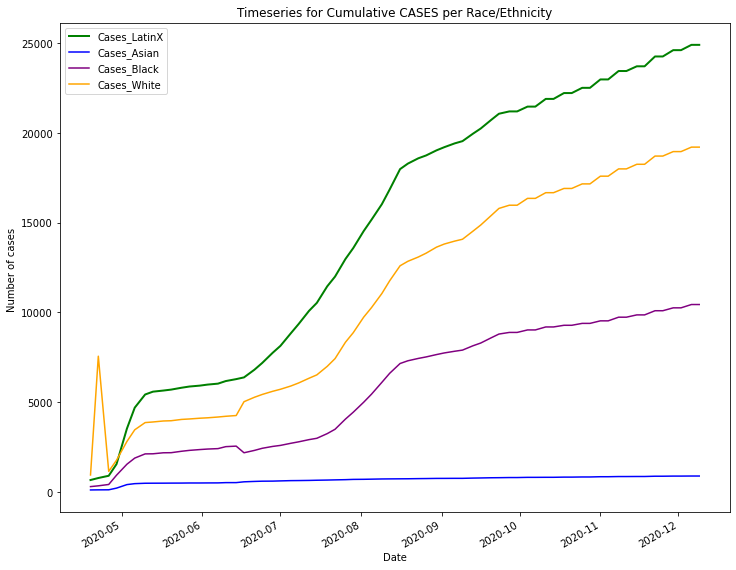

In [92]:
# Now that we have access to TX historical data, we can plot some trends

# Let's start by plotting historical case trends
casesHL = texasHistorical[['Date', 'Cases_LatinX']]
casesHL.set_index('Date', inplace=True)

casesAS = texasHistorical[['Date', 'Cases_Asian']]
casesAS.set_index('Date', inplace=True)

casesBAA = texasHistorical[['Date', 'Cases_Black']]
casesBAA.set_index('Date', inplace=True)

casesWH = texasHistorical[['Date', 'Cases_White']]
casesWH.set_index('Date', inplace=True)

#plot all in same graph
ax = casesHL.plot(figsize=(12, 10), title='Timeseries for Cumulative CASES per Race/Ethnicity',linewidth=2, color='green')
ax.set_ylabel("Number of cases ")
casesAS.plot(ax=ax, color='blue')
casesBAA.plot(ax=ax, color='purple')
casesWH.plot(ax=ax, color='orange')

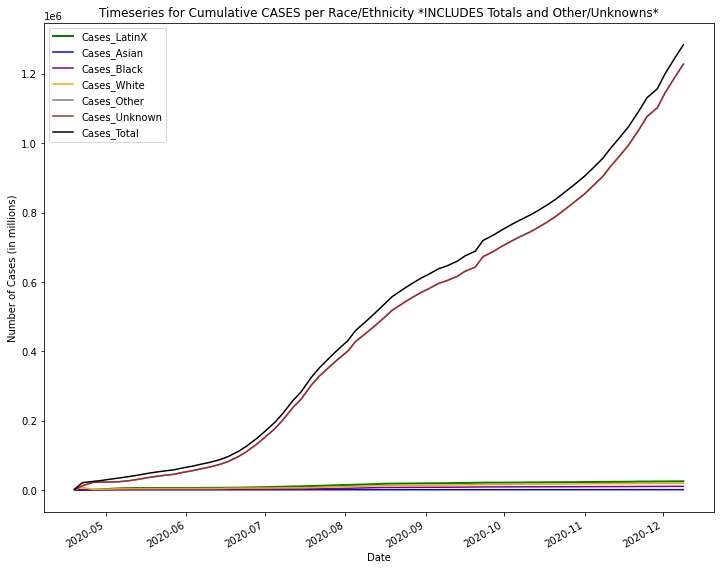

In [93]:
# We have excluded cases by total, other, and unknown categories in the plot above
# To get a sense of the bigger picture, let's plot the same graph above but with these categories

casesHL = texasHistorical[['Date', 'Cases_LatinX']]
casesHL.set_index('Date', inplace=True)

casesAS = texasHistorical[['Date', 'Cases_Asian']]
casesAS.set_index('Date', inplace=True)

casesBAA = texasHistorical[['Date', 'Cases_Black']]
casesBAA.set_index('Date', inplace=True)

casesWH = texasHistorical[['Date', 'Cases_White']]
casesWH.set_index('Date', inplace=True)

casesOTH = texasHistorical[['Date', 'Cases_Other']]
casesOTH.set_index('Date', inplace=True)

casesUNK = texasHistorical[['Date', 'Cases_Unknown']]
casesUNK.set_index('Date', inplace=True)

casesTOTAL = texasHistorical[['Date', 'Cases_Total']]
casesTOTAL.set_index('Date', inplace=True)

#plot all in same graph
ax = casesHL.plot(figsize=(12, 10), title='Timeseries for Cumulative CASES per Race/Ethnicity *INCLUDES Totals and Other/Unknowns*',linewidth=2, color='green')
ax.set_ylabel("Number of Cases (in millions)")
casesAS.plot(ax=ax, color='blue')
casesBAA.plot(ax=ax, color='purple')
casesWH.plot(ax=ax, color='orange')
casesOTH.plot(ax=ax, color='gray')
casesUNK.plot(ax=ax, color='brown')
casesTOTAL.plot(ax=ax, color='black')

# NOTE: Notice that this plot shows us that most of the TX data isn't categorized by race/ethnicity
# Instead, most of this is unknown/other. 

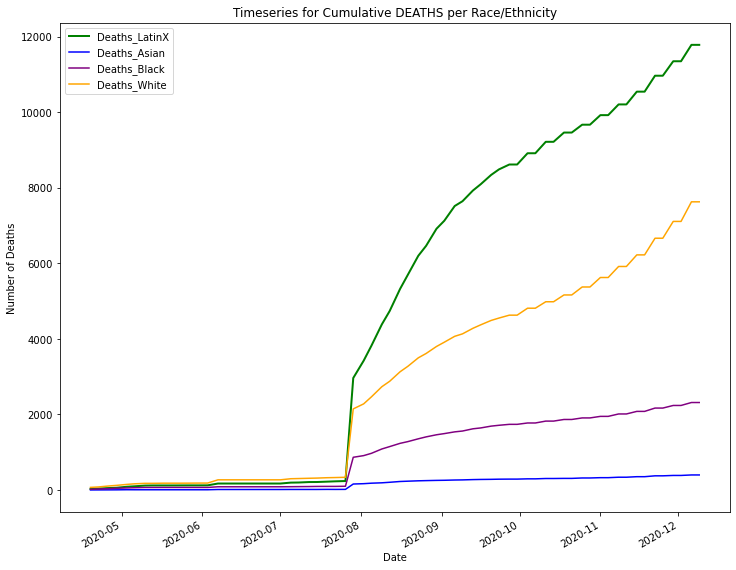

In [94]:
# Let's repeat what we did above, but this time to visualize death data

deathsHL = texasHistorical[['Date', 'Deaths_LatinX']]
deathsHL.set_index('Date', inplace=True)

deathsAS = texasHistorical[['Date', 'Deaths_Asian']]
deathsAS.set_index('Date', inplace=True)

deathsBAA = texasHistorical[['Date', 'Deaths_Black']]
deathsBAA.set_index('Date', inplace=True)

deathsWH = texasHistorical[['Date', 'Deaths_White']]
deathsWH.set_index('Date', inplace=True)

#plot all in same graph
ax = deathsHL.plot(figsize=(12, 10), title='Timeseries for Cumulative DEATHS per Race/Ethnicity',linewidth=2, color='green')
ax.set_ylabel("Number of Deaths")
deathsAS.plot(ax=ax, color='blue')
deathsBAA.plot(ax=ax, color='purple')
deathsWH.plot(ax=ax, color='orange')

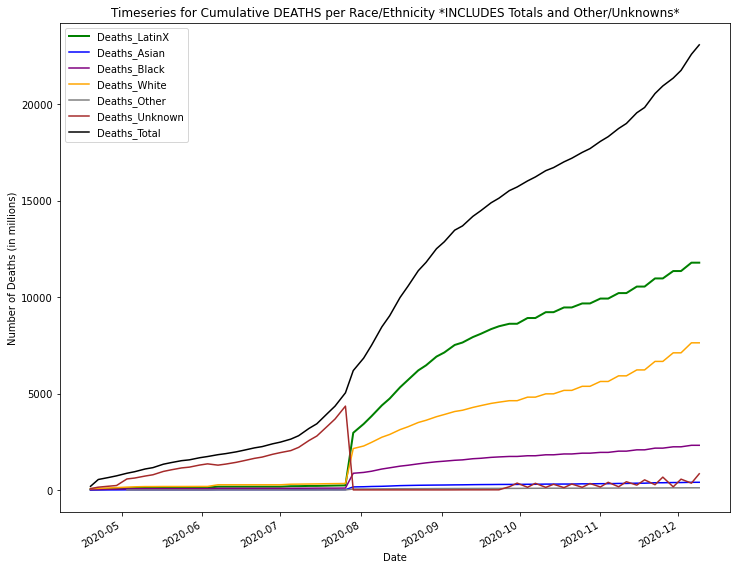

In [95]:
# We have excluded cases by total, other, and unknown categories in the plot above
# To get a sense of the bigger picture, let's plot the same graph above but with these categories

deathsHL = texasHistorical[['Date', 'Deaths_LatinX']]
deathsHL.set_index('Date', inplace=True)

deathsAS = texasHistorical[['Date', 'Deaths_Asian']]
deathsAS.set_index('Date', inplace=True)

deathsBAA = texasHistorical[['Date', 'Deaths_Black']]
deathsBAA.set_index('Date', inplace=True)

deathsWH = texasHistorical[['Date', 'Deaths_White']]
deathsWH.set_index('Date', inplace=True)

deathsOTH = texasHistorical[['Date', 'Deaths_Other']]
deathsOTH.set_index('Date', inplace=True)

deathsUNK = texasHistorical[['Date', 'Deaths_Unknown']]
deathsUNK.set_index('Date', inplace=True)

deathsTOTAL = texasHistorical[['Date', 'Deaths_Total']]
deathsTOTAL.set_index('Date', inplace=True)

#plot all in same graph
ax = deathsHL.plot(figsize=(12, 10), title='Timeseries for Cumulative DEATHS per Race/Ethnicity *INCLUDES Totals and Other/Unknowns*',linewidth=2, color='green')
ax.set_ylabel("Number of Deaths")
deathsAS.plot(ax=ax, color='blue')
deathsBAA.plot(ax=ax, color='purple')
deathsWH.plot(ax=ax, color='orange')
deathsOTH.plot(ax=ax, color='gray')
deathsUNK.plot(ax=ax, color='brown')
deathsTOTAL.plot(ax=ax, color='black')

# NOTE: Something interesting to notice is how the Deaths_Unknown value suddenly dipped around August, 
# but values for all other races/ethnicties spiked after this. We can hypothesize that this is because 
# TX started categorizing previous deaths into demographic categories
# this is one of the ways visualizing historical data can be helpful